In [1]:
#Notebook to analyze IbIs scans in NEXUS R5
#Fixed Gain = 4
#Use clustering to average over bias points, this cleans things up a lot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import scdmsPyTools.BatTools.IO as io
from glob import glob
import pickle

# 102mk 1400->-1400

In [139]:
#Series number, temperature and channel

#dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
dir=""
det="Z1"

ser = ["25200319_0104"]

temp = ["102k"]

chan = ["PES1"]

Nmeas = 281

In [140]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/25200319_0104.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/25200319_0104.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

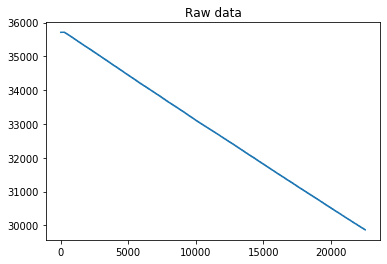

In [141]:
plt.plot(means[0])
#plt.xlim(0,10000)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [142]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [143]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-1400,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

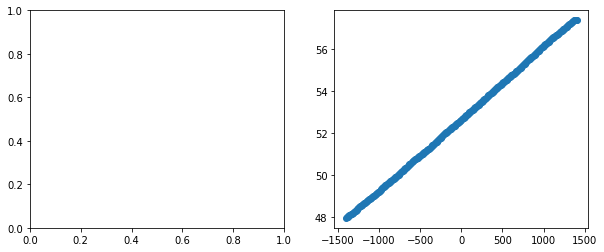

In [144]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')

In [145]:
x_0 = -3.42463869
y_0 = 52.7055728

In [146]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*((IV['Ib']-x_0)/(IV['Is']-y_0)-1)-Rp

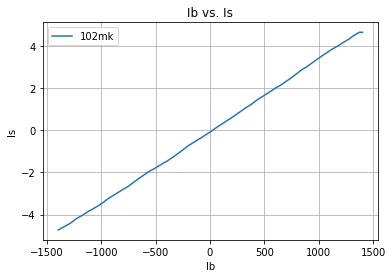

In [147]:
plt.plot(IVs[0]['Ib']-x_0,IVs[0]['Is']-y_0)
plt.title("Ib vs. Is")
plt.xlabel("Ib")
plt.ylabel("Is")
plt.legend(["102mk"])
plt.grid()

(2000, 3000)

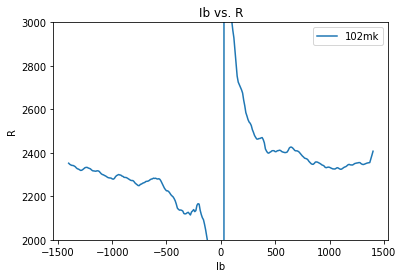

In [148]:
plt.plot(IVs[0]['Ib'],IVs[0]['R'])
plt.title("Ib vs. R")
plt.xlabel("Ib")
plt.ylabel("R")
plt.legend(["102mk"])
plt.ylim(2000,3000)

In [149]:
IV['Ib'] = IV['Ib']-x_0
IV['Is'] = IV['Is']-y_0

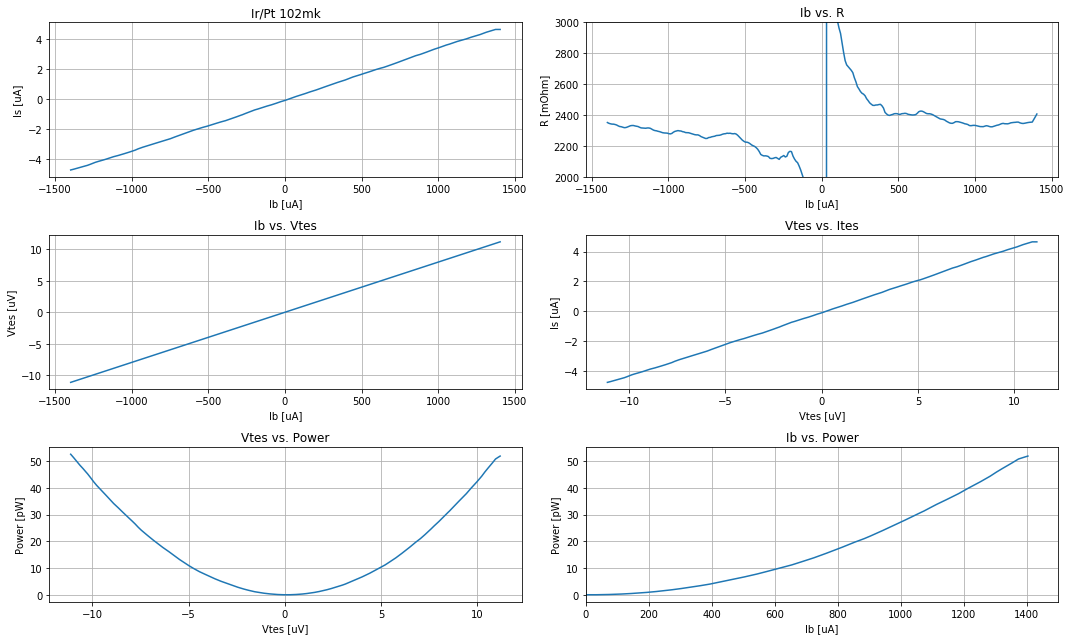

In [151]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    #axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    axj.set_ylim(2000,3000)
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 102mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

# 86mk 1400->-1400

In [95]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200319_0027"]

temp = ["86.2 mk"]

chan = ["PES1"]

Nmeas = 281

In [96]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/25200319_0027.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/25200319_0027.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

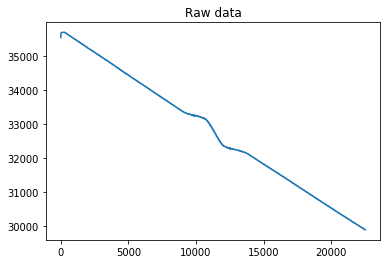

In [97]:
plt.plot(means[0])
#plt.xlim(0,10000)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [98]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [99]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-1400,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

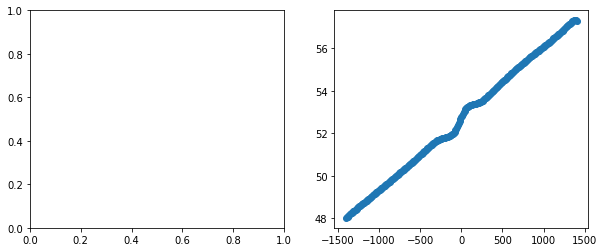

In [100]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>1000) & (IV['Ib']<1200)], IV['Is'][(IV['Ib']>1000) & (IV['Ib']<1200)],1)
    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<50) & (IV['Ib']>-50)], IV['Is'][((IV['Ib']<50)) & (IV['Ib']>-50)],1)

In [101]:
p1 = np.poly1d(fit_normal)
p2 = np.poly1d(fit_spcond)
x_0 = np.roots(p2-p1)
y_0 = p1(x_0)
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

In [102]:
print(x_0,y_0)

[-3.42463869] [52.7055728]


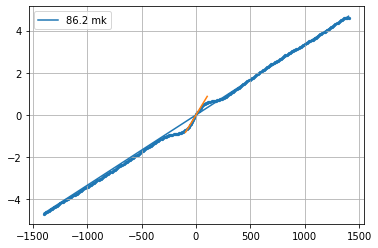

In [103]:
plt.scatter(IVs[0]['Ib'],IVs[0]['Is'],s=5)
plt.plot(np.linspace(-1400,1400,300)-x_0,p1(np.linspace(-1400,1400,300))-y_0)
plt.plot(np.linspace(-100,100,300)-x_0,p2(np.linspace(-100,100,300))-y_0)
plt.grid()
plt.legend([temp[0]])

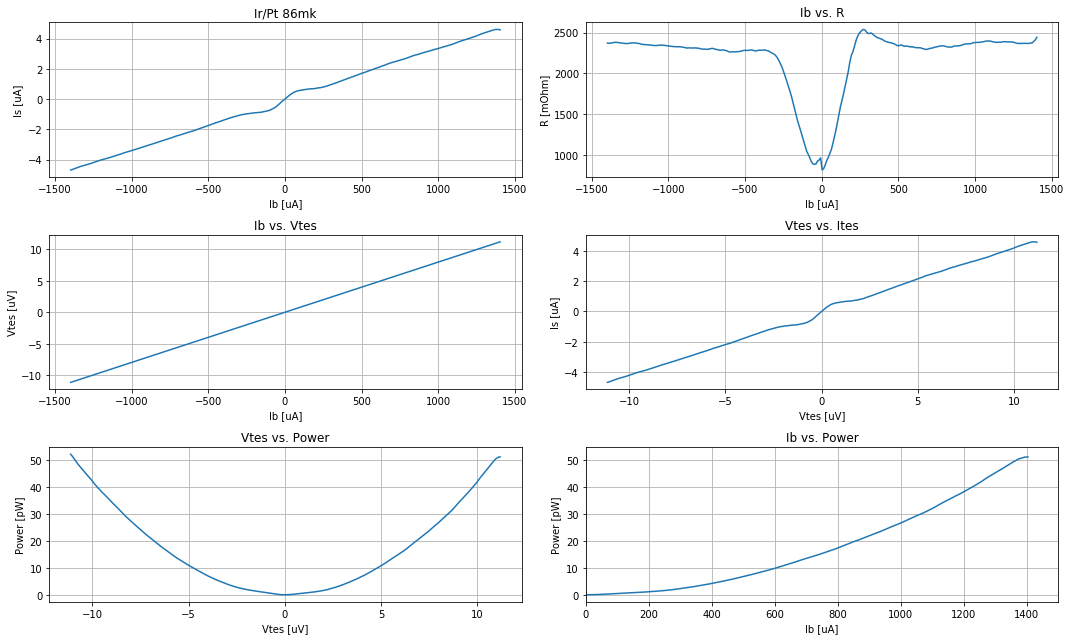

In [104]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    #axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 86mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

# 88mk 1400->-1400

In [153]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200318_2356"]

temp = ["88 mk"]

chan = ["PES1"]

Nmeas = 281

In [154]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/25200318_2356.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/25200318_2356.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

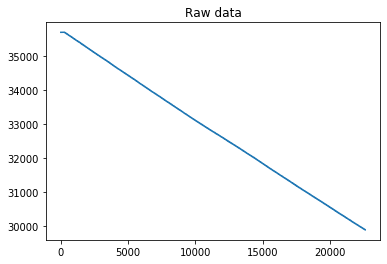

In [155]:
plt.plot(means[0])
#plt.xlim(0,10000)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [156]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [157]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-1400,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

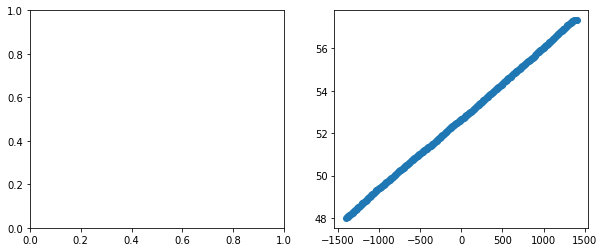

In [158]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')

In [159]:
x_0 = -3.42463869
y_0 = 52.7055728

In [160]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*((IV['Ib'] - x_0)/(IV['Is'] - y_0)-1)-Rp

Text(0.5, 1.0, 'Ib vs. R @ 88mk')

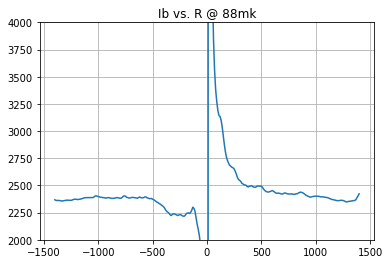

In [161]:
plt.plot(IV['Ib'],IV['R'])
#plt.yscale('log')
plt.ylim(2000,4000)
plt.grid()
plt.title("Ib vs. R @ 88mk")

In [78]:
IV['Ib'] = IV['Ib'] - x_0
IV['Is'] = IV['Is'] - y_0

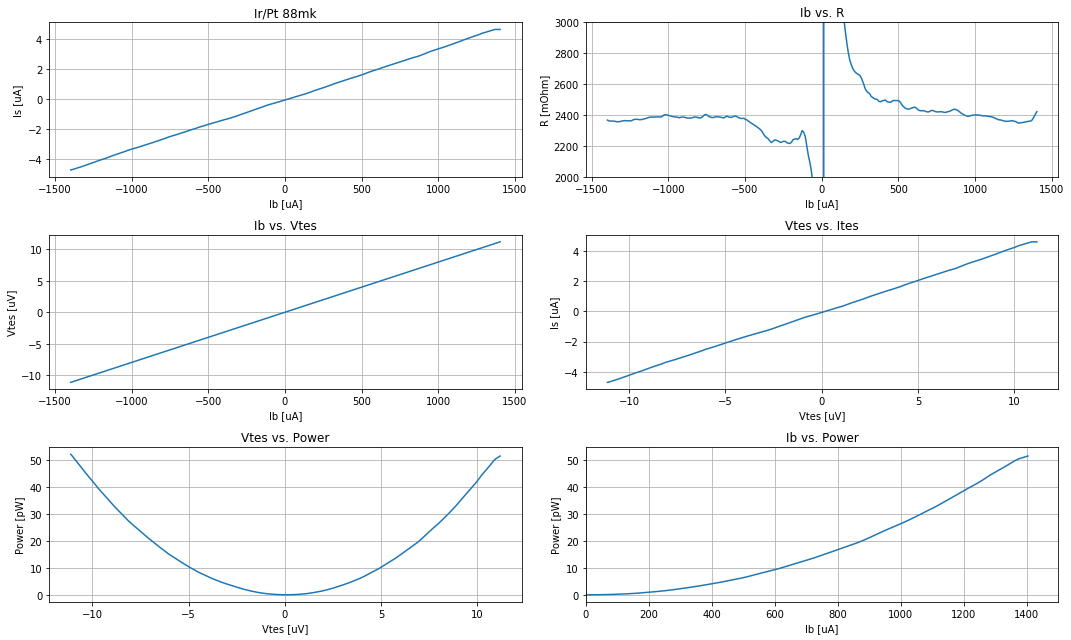

In [81]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    #axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    axj.set_ylim(2000,3000)
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
   
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 88mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

# 90mk 1400->-1400

In [163]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200318_2328"]

temp = ["89.9 mk"]

chan = ["PES1"]

Nmeas = 281

In [164]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/25200318_2328.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/25200318_2328.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

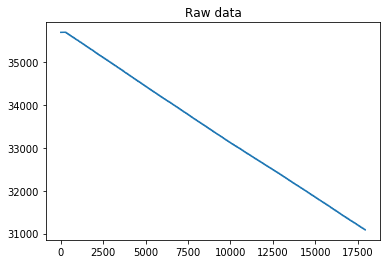

In [165]:
plt.plot(means[0])
#plt.xlim(0,10000)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [166]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [167]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-1400,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

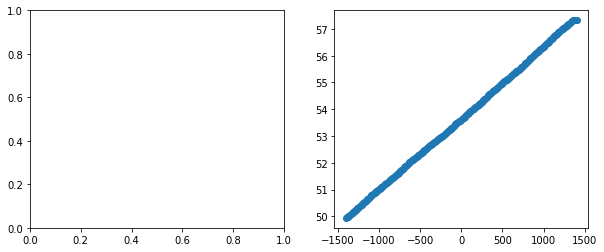

In [168]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
#    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>1000) & (IV['Ib']<1200)], IV['Is'][(IV['Ib']>1000) & (IV['Ib']<1200)],1)
#    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<50) & (IV['Ib']>-50)], IV['Is'][((IV['Ib']<50)) & (IV['Ib']>-50)],1)

In [169]:
x_0 = -3.42463869
y_0 = 52.7055728

In [170]:
IV['Ib'] = IV['Ib'] - x_0
IV['Is'] = IV['Is'] - y_0

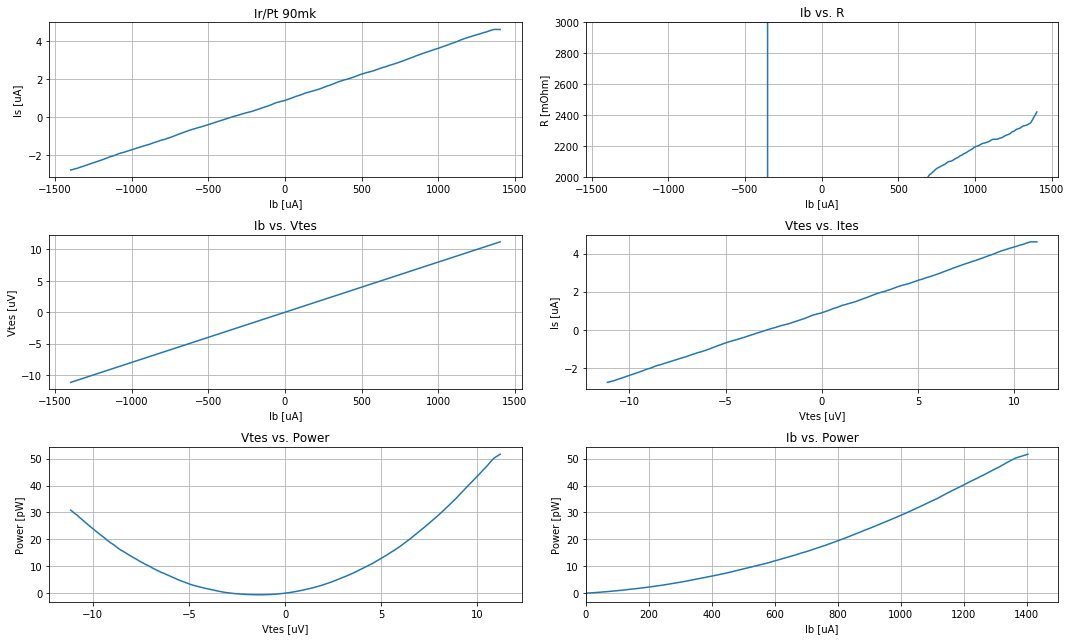

In [175]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    #axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
#    axj.set_yscale("log")
    axj.set_ylim(2000,3000)
    #axj.set_ylim(1000,3000)
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 90mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

# 85mk 1400->-1400

In [176]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200318_2246"]

temp = ["85 mk"]

chan = ["PES1"]

Nmeas = 281

In [177]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/25200318_2246.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/25200318_2246.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

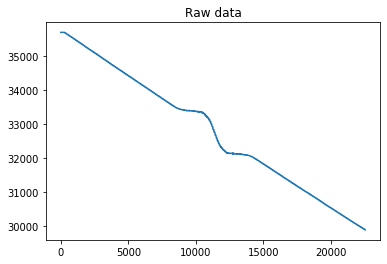

In [178]:
plt.plot(means[0])
#plt.xlim(0,10000)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [179]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [180]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-1400,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

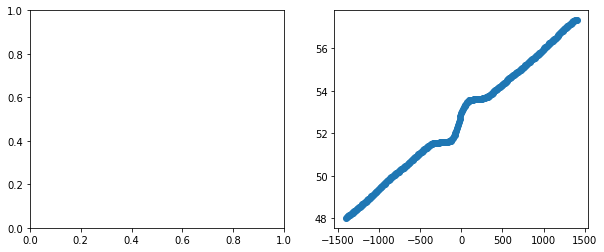

In [187]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>800) & (IV['Ib']<1000)], IV['Is'][(IV['Ib']>800) & (IV['Ib']<1000)],1)
    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<50) & (IV['Ib']>-50)], IV['Is'][((IV['Ib']<50)) & (IV['Ib']>-50)],1)

In [188]:
p1 = np.poly1d(fit_normal)
p2 = np.poly1d(fit_spcond)
x_0 = np.roots(p2-p1)
y_0 = p1(x_0)
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

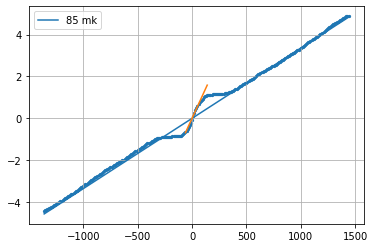

In [189]:
plt.scatter(IVs[0]['Ib'],IVs[0]['Is'],s=5)
plt.plot(np.linspace(-1400,1400,300)-x_0,p1(np.linspace(-1400,1400,300))-y_0)
plt.plot(np.linspace(-100,100,300)-x_0,p2(np.linspace(-100,100,300))-y_0)
plt.grid()
plt.legend([temp[0]])

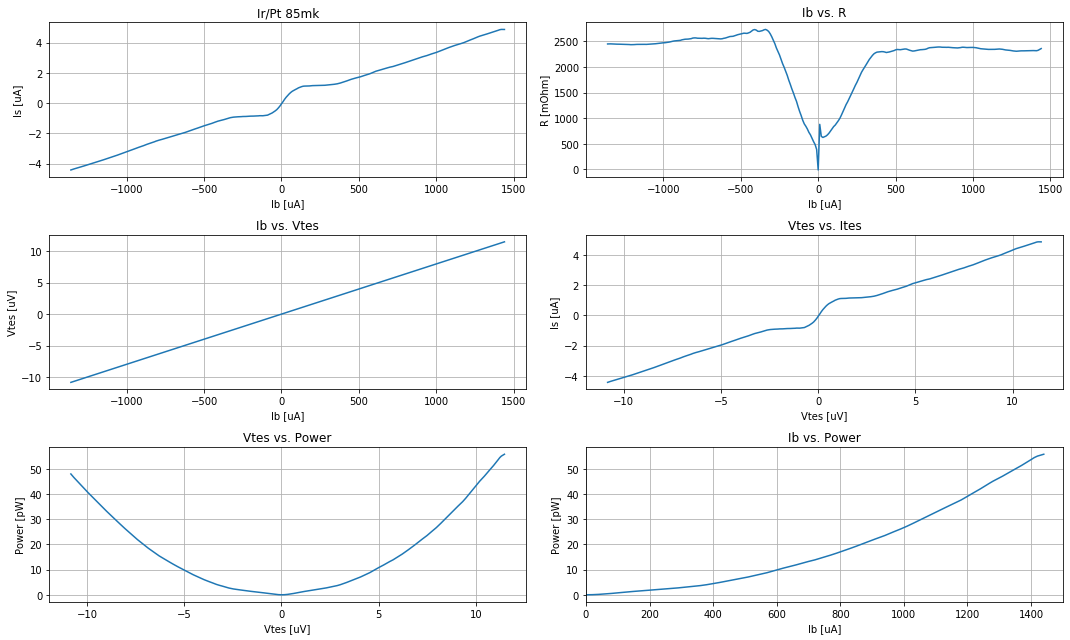

In [190]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    #axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 85mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

# 95mk

In [601]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200318_2125"]

temp = ["95 mk"]

chan = ["PES1"]

Nmeas = 281

In [602]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/25200318_2125.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/25200318_2125.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

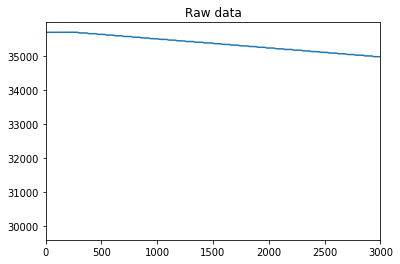

In [603]:
plt.plot(means[0])
plt.xlim(0,3000)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [604]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [613]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-1400,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

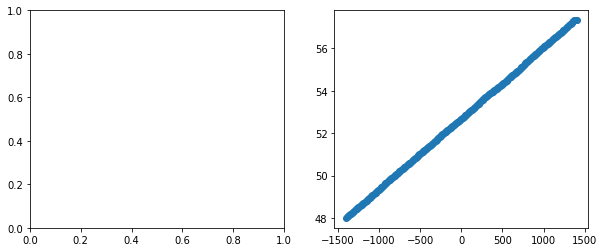

In [615]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
#    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>1000) & (IV['Ib']<1200)], IV['Is'][(IV['Ib']>1000) & (IV['Ib']<1200)],1)
#    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<-150) & (IV['Ib']>-250)], IV['Is'][((IV['Ib']<-150)) & (IV['Ib']>-250)],1)

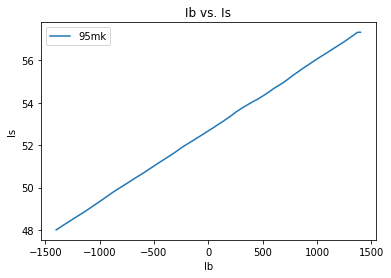

In [629]:
plt.plot(IVs[0]['Ib'],IVs[0]['Is'])
plt.title("Ib vs. Is")
plt.xlabel("Ib")
plt.ylabel("Is")
plt.legend(["95mk"])

In [625]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
Ib_Is = 1/np.polyfit(IV['Ib'], IV['Is'],1)[0]
for IV in IVs:
    IV['R']=np.array([Rsh*(Ib_Is-1)-Rp]*len(IV['Ib']))
    

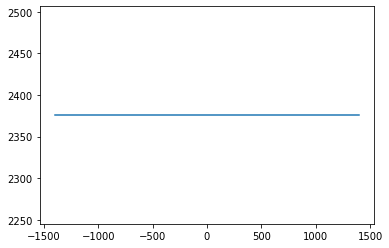

In [626]:
plt.plot(IVs[0]['Ib'],IVs[0]['R'])

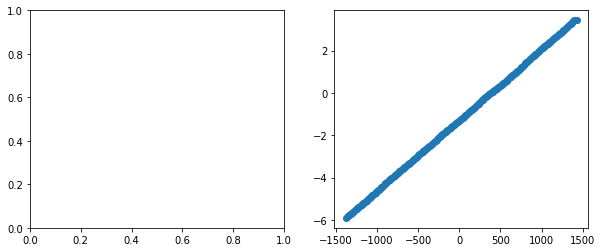

In [612]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')

# 85 mk

In [554]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200318_1935"]

temp = ["85 mk"]

chan = ["PES1"]

Nmeas = 281

In [495]:
#Calculate means
##This takes a while. Can also load saved ones below##
if False:
    means = pickle.load( open( "data/25200318_1935.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/25200318_1935.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

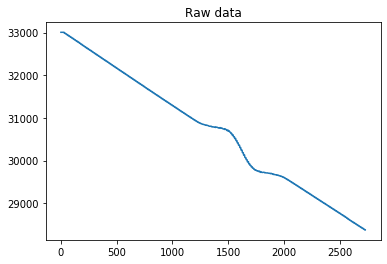

In [496]:
plt.plot(means[0])
#plt.xlim(0,700)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [497]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [543]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-1400,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

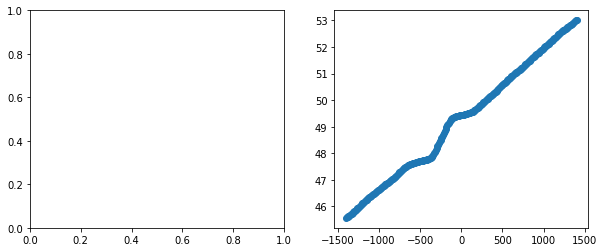

In [544]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>1000) & (IV['Ib']<1200)], IV['Is'][(IV['Ib']>1000) & (IV['Ib']<1200)],1)
    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<-150) & (IV['Ib']>-250)], IV['Is'][((IV['Ib']<-150)) & (IV['Ib']>-250)],1)

In [545]:
p1 = np.poly1d(fit_normal)
p2 = np.poly1d(fit_spcond)
x_0 = np.roots(p2-p1)
y_0 = p1(x_0)
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

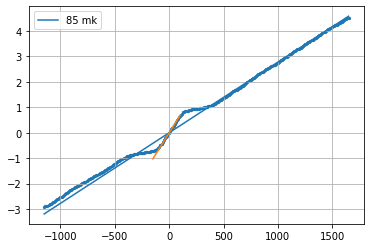

In [546]:
plt.scatter(IVs[0]['Ib'],IVs[0]['Is'],s=5)
plt.plot(np.linspace(-1400,1400,300)-x_0,p1(np.linspace(-1400,1400,300))-y_0)
plt.plot(np.linspace(-400,-150,300)-x_0,p2(np.linspace(-400,-150,300))-y_0)
plt.grid()
plt.legend([temp[0]])

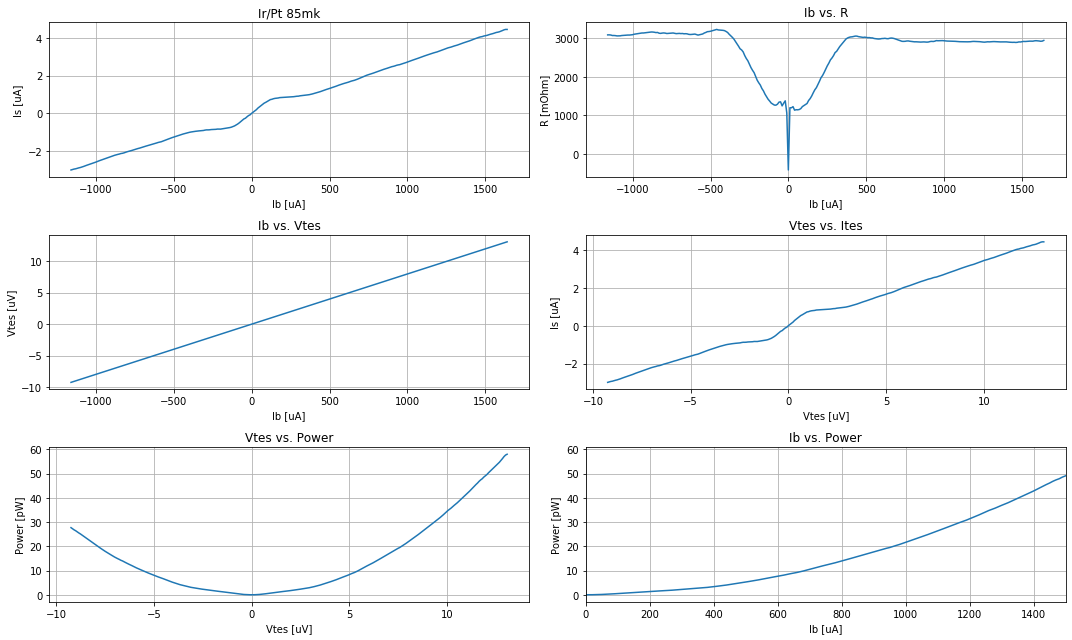

In [524]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    #axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 85mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

# 80 mk

In [438]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200309_1631"]

temp = ["80 mk"]

chan = ["PES1"]

Nmeas = 141

In [439]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/80mk.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/80mk.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

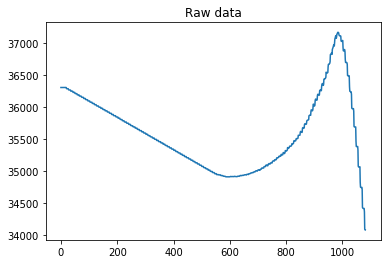

In [440]:
plt.plot(means[0])
#plt.xlim(0,700)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

## Convert to Is and correction

In [441]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [442]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(0,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

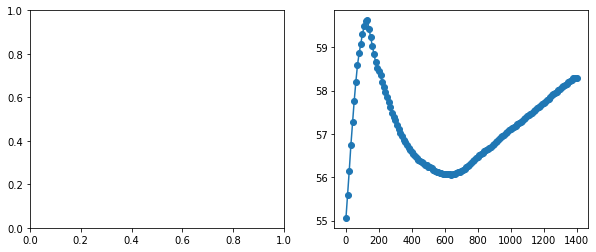

In [443]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'][IV['Ib']>800], IV['Is'][IV['Ib']>800],1)
    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<80)], IV['Is'][((IV['Ib']<80))],1)

In [444]:
p1 = np.poly1d(fit_normal)
p2 = np.poly1d(fit_spcond)
x_0 = np.roots(p2-p1)
y_0 = p1(x_0)
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

In [446]:
print(x_0,y_0)

[-23.86172899] [53.90477601]


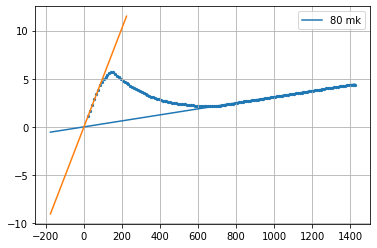

In [207]:
plt.scatter(IVs[0]['Ib'],IVs[0]['Is'],s=5)
plt.plot(np.linspace(-200,1400,300)-x_0,p1(np.linspace(-200,1400,300))-y_0)
plt.plot(np.linspace(-200,200,300)-x_0,p2(np.linspace(-200,200,300))-y_0)
plt.grid()
plt.legend([temp[0]])

## Calculate Resistance

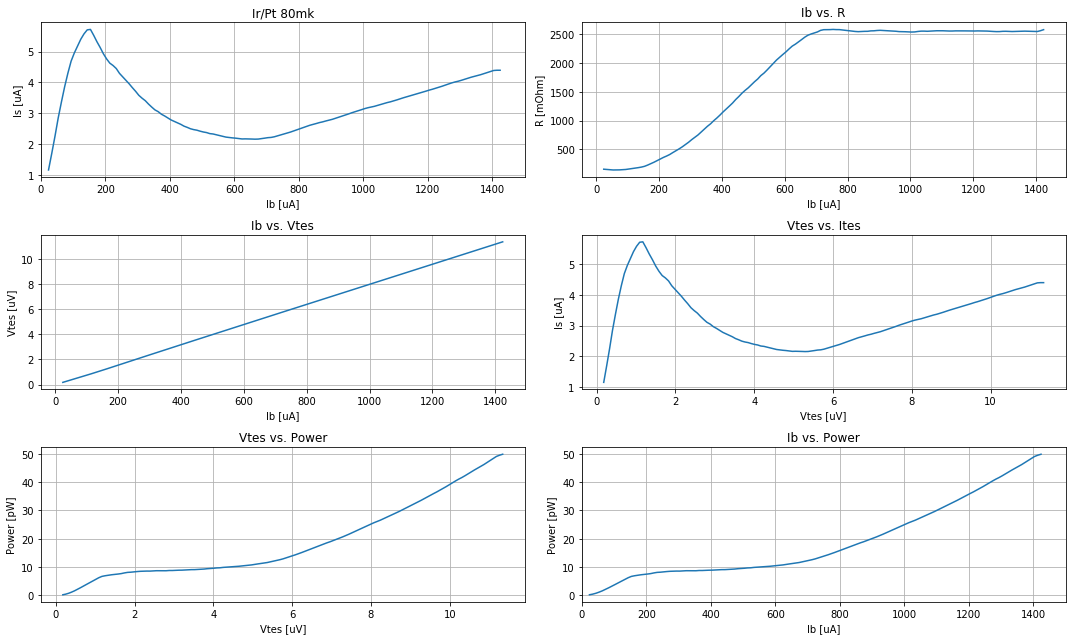

In [238]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 80mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

Text(0.5, 1.0, 'Ites vs. R')

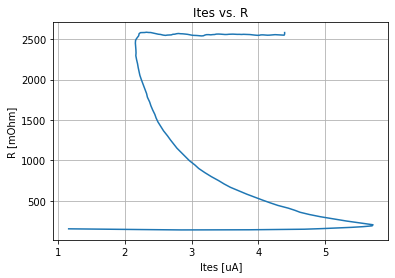

In [242]:
plt.plot(IVs[0]['Is'],IVs[0]['R'])
plt.xlabel('Ites [uA]')
plt.ylabel('R [mOhm]')
plt.grid()
plt.title("Ites vs. R")

# 75mk

In [356]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200309_1712"]

temp = ["75 mk"]

chan = ["PES1"]

Nmeas = 141

In [357]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/75mk.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/75mk.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

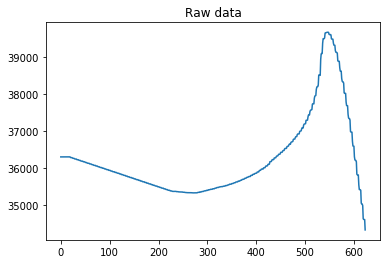

In [358]:
plt.plot(means[0])
#plt.xlim(0,700)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [359]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [360]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(0,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

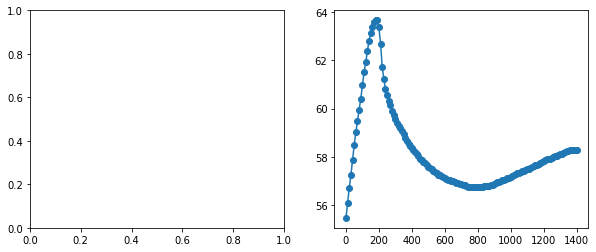

In [361]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'][IV['Ib']>800], IV['Is'][IV['Ib']>800],1)
    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<80)], IV['Is'][((IV['Ib']<80))],1)

In [362]:
p1 = np.poly1d(fit_normal)
p2 = np.poly1d(fit_spcond)
x_0 = np.roots(p2-p1)
y_0 = p1(x_0)
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

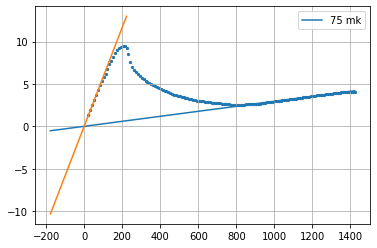

In [363]:
plt.scatter(IVs[0]['Ib'],IVs[0]['Is'],s=5)
plt.plot(np.linspace(-200,1400,300)-x_0,p1(np.linspace(-200,1400,300))-y_0)
plt.plot(np.linspace(-200,200,300)-x_0,p2(np.linspace(-200,200,300))-y_0)
plt.grid()
plt.legend([temp[0]])

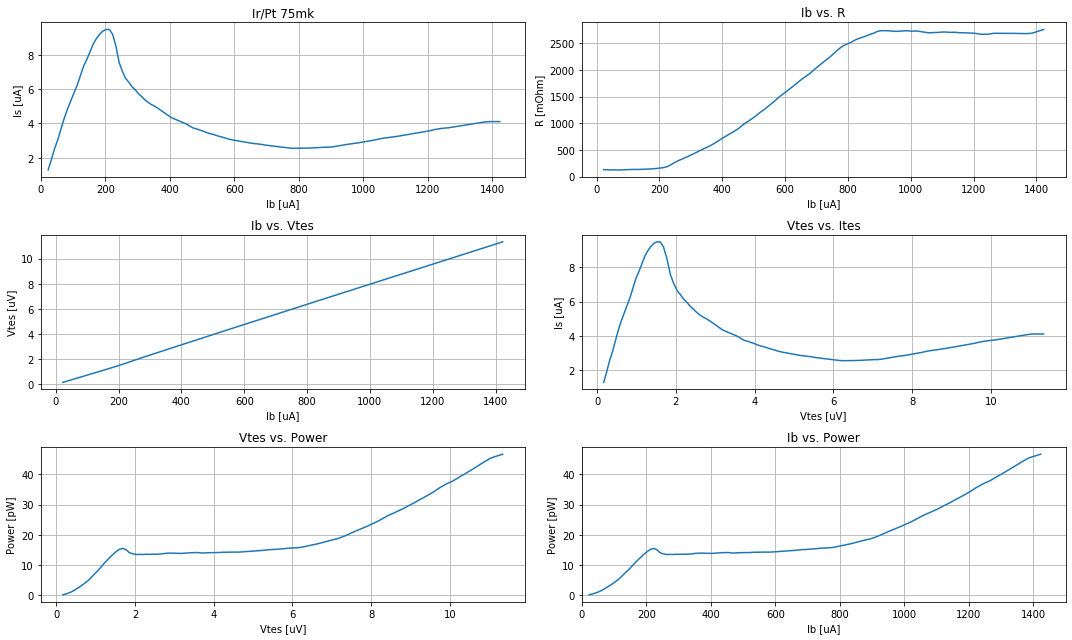

In [364]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
    axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 75mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

# 80mk 1200->-2000

In [467]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200309_1954"]

temp = ["80 mk"]

chan = ["PES1"]

Nmeas = 221

In [469]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/80mk_1200_-2000.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/80mk_1200_-2000.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

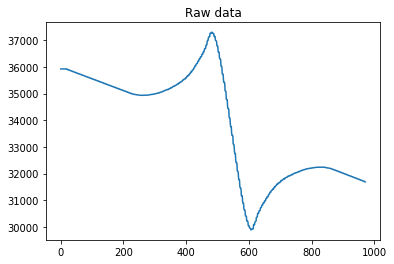

In [470]:
plt.plot(means[0])
#plt.xlim(0,700)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [471]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [472]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(0,1400,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

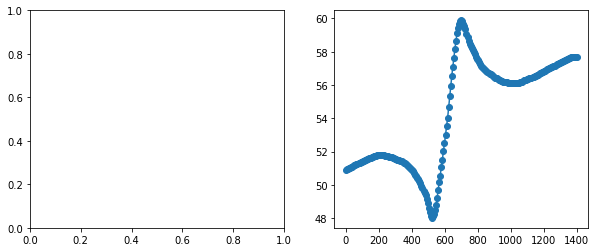

In [473]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>1200) & (IV['Ib']<1350)], IV['Is'][(IV['Ib']>1200)&(IV['Ib']<1350)],1)
    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<650) & (IV['Ib']>600) ], IV['Is'][(IV['Ib']<650) & (IV['Ib']>600) ],1)

In [474]:
p1 = np.poly1d(fit_normal)
p2 = np.poly1d(fit_spcond)
x_0 = np.roots(p2-p1)
y_0 = p1(x_0)
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

In [475]:
print(x_0,y_0)

[614.7186815] [53.88892785]


Text(0.5, 1.0, 'Ibias vs Ites')

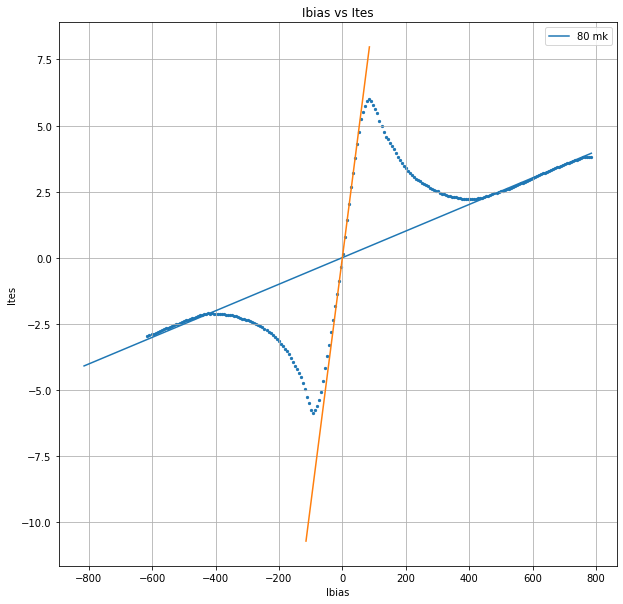

In [476]:
plt.figure(figsize=(10,10))
plt.scatter(IVs[0]['Ib'],IVs[0]['Is'],s=5)
plt.plot(np.linspace(-200,1400,300)-x_0,p1(np.linspace(-200,1400,300))-y_0)
plt.plot(np.linspace(500,700,300)-x_0,p2(np.linspace(500,700,300))-y_0)
plt.grid()
plt.legend([temp[0]])
plt.xlabel("Ibias")
plt.ylabel("Ites")
plt.title("Ibias vs Ites")

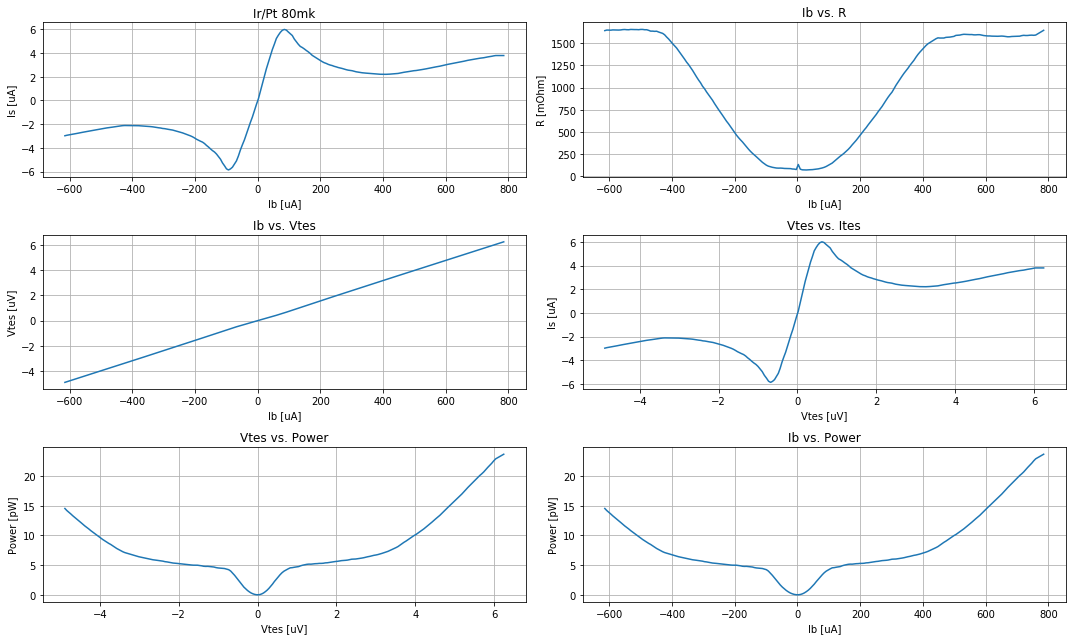

In [477]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
#    axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
#    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 80mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()

# 0309_2226 70mk

In [374]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200309_2226"]

temp = ["70 mk"]

chan = ["PES1"]

Nmeas = 301

In [375]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/80mk_2226.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/80mk_2226.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

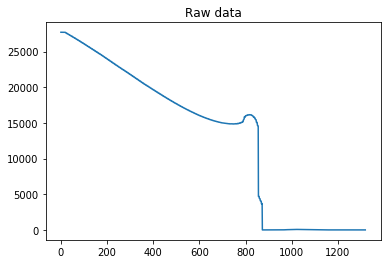

In [376]:
plt.plot(means[0])
#plt.xlim(0,700)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [377]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [378]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(-500,100,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

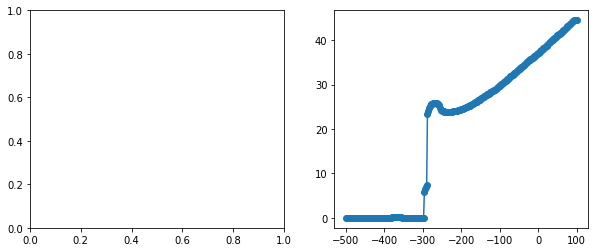

In [379]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
#    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>1200) & (IV['Ib']<1350)], IV['Is'][(IV['Ib']>1200)&(IV['Ib']<1350)],1)
#    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<650) & (IV['Ib']>600) ], IV['Is'][(IV['Ib']<650) & (IV['Ib']>600) ],1)

In [380]:
def SquidJump(Ib,Is):
    threshold = 5
    return np.where([np.diff(Is)>threshold])[1]

In [381]:
jumppt = SquidJump(IVs[0]['Ib'],IVs[0]['Is'])
jumppt

array([101, 105])

In [382]:
jumppt = SquidJump(IVs[0]['Ib'],IVs[0]['Is'])
IVs[0]['Is'][0:jumppt[0]+1] = IVs[0]['Is'][0:jumppt[0]+1] + (IVs[0]['Is'][jumppt[0]+1] - IVs[0]['Is'][jumppt[0]])
IVs[0]['Is'][0:jumppt[1]+1] = IVs[0]['Is'][0:jumppt[1]+1] + (IVs[0]['Is'][jumppt[1]+1] - IVs[0]['Is'][jumppt[1]])

In [383]:
IVs[0]['Ib'][jumppt]

array([-298., -290.])

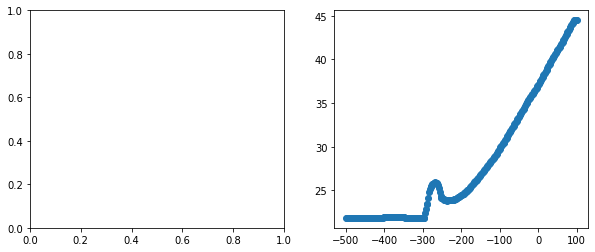

In [384]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'][(IV['Ib']>0)], IV['Is'][(IV['Ib']>0)],1)
    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<-290) & (IV['Ib']>-298) ], IV['Is'][(IV['Ib']<-290) & (IV['Ib']>-298) ],1)

In [385]:
p1 = np.poly1d(fit_normal)
p2 = np.poly1d(fit_spcond)
x_0 = np.roots(p2-p1)
y_0 = p1(x_0)
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

Text(0.5, 1.0, 'Ibias vs Ites')

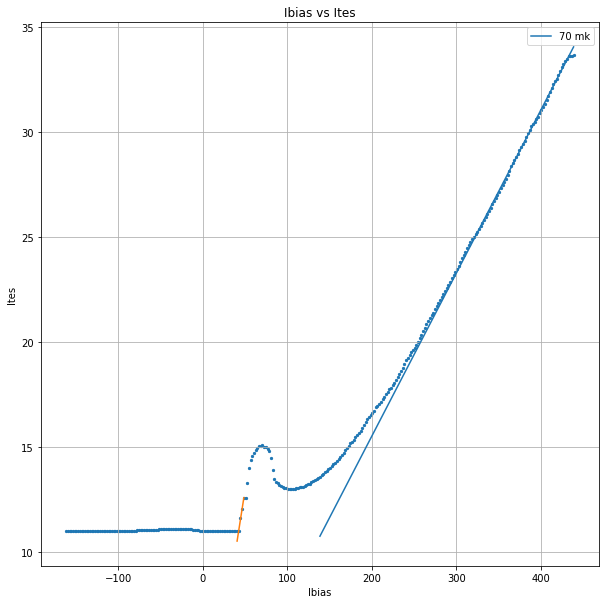

In [386]:
plt.figure(figsize=(10,10))
plt.scatter(IVs[0]['Ib'],IVs[0]['Is'],s=5)
plt.plot(np.linspace(-200,100,300)-x_0,p1(np.linspace(-200,100,300))-y_0)
plt.plot(np.linspace(-298,-290,9)-x_0,p2(np.linspace(-298,-290,9))-y_0)
plt.grid()
plt.legend([temp[0]])
plt.xlabel("Ibias")
plt.ylabel("Ites")
plt.title("Ibias vs Ites")

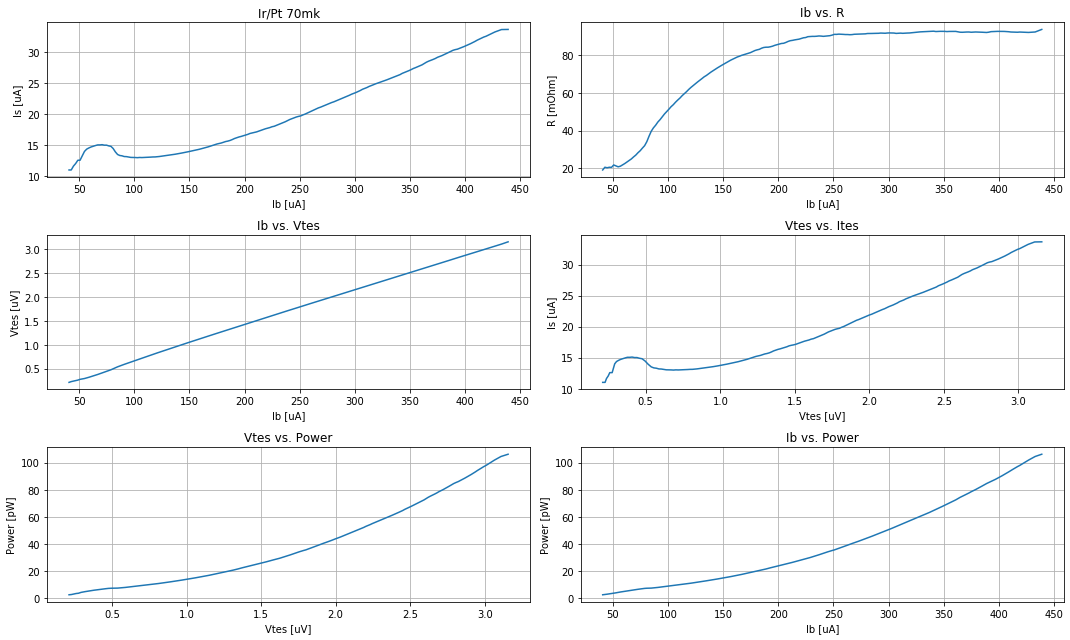

In [387]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'][jumppt[0]:],IV['Is'][jumppt[0]:],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
#    axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'][jumppt[0]:],IV['R'][jumppt[0]:],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'][jumppt[0]:],(IV['Is']*IV['R']/1000)[jumppt[0]:])
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot((IV['Is']*IV['R']/1000)[jumppt[0]:],IV['Is'][jumppt[0]:])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot((IV['Is']*IV['R']/1000)[jumppt[0]:],(IV['Is']**2*IV['R']/1000)[jumppt[0]:])
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'][jumppt[0]:],(IV['Is']**2*IV['R']/1000)[jumppt[0]:])
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
#    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 70mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()

# 85 mk (Only normal)

In [456]:
#Series number, temperature and channel

dir="/gpfs/slac/staas/fs1/g/supercdms/tf/nexus/midasdata/NEXUS/R5/Raw/"
det="Z1"

ser = ["25200309_1529"]

temp = ["85 mk"]

chan = ["PES1"]

Nmeas = 101

In [457]:
#Calculate means
##This takes a while. Can also load saved ones below##
if True:
    means = pickle.load( open( "data/85mk.pkl", "rb" ) )
else:
    means=[]
    for i,(ser_i, chan_i) in enumerate(zip(ser,chan)):
        dumplist=sorted(glob(dir+ser_i+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump,channelList=chan)
            if 'Z1' in res.keys():
                traces=res[det][chan_i]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means.append(np.array(means_dump))
        print("{}%".format(np.round(100*(i+1)/len(ser))), end="\r", flush=True)
        pickle.dump( means, open( "data/85mk.pkl", "wb" ) )

Text(0.5, 1.0, 'Raw data')

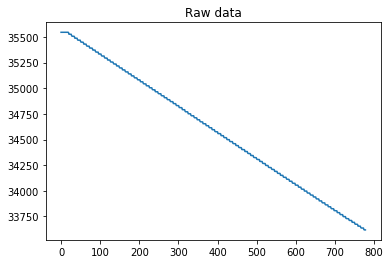

In [458]:
plt.plot(means[0])
#plt.xlim(0,700)
#plt.ylim(0.00009,0.0001)
plt.title("Raw data")

In [459]:
#Convert from ADC to Is [A]

r_turns=14 #SQUID turns ration, 14+/-0.3 depending on the chip
R_FB=1.39e3 #Feedback resistor [Ohm]
G_PGA=1 #Variable PGA (driver) gain 1,2,4,8
G_fixed=4 #Fixed DCRC gain. 2 before Feb 28th, 4 after Feb 28th
ADCperV=2**16/8.192 #ADC conversion
traceGain=r_turns*R_FB*G_PGA*G_fixed*ADCperV #Multiplicative factor in: G*I_s = ADC

means=[mean_i/traceGain for mean_i in means]

In [460]:
#Use clustering to average over each Ib setting
from sklearn.cluster import KMeans

IVs=[]
for i,mean_i in enumerate(means):
    ev=np.arange(len(mean_i))
    X=np.array([ev,mean_i*1e6])
    kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)
    
    ev_cent=kmeans.cluster_centers_.T[0]
    Is_cent=kmeans.cluster_centers_.T[1]
    
    Is=Is_cent[np.argsort(ev_cent)][::-1]
    
    Ib=np.linspace(0,1000,Nmeas)
    IVs.append({'temp':temp[i],'chan':chan[i],'series':ser[i],'Ib':Ib,'Is':Is})

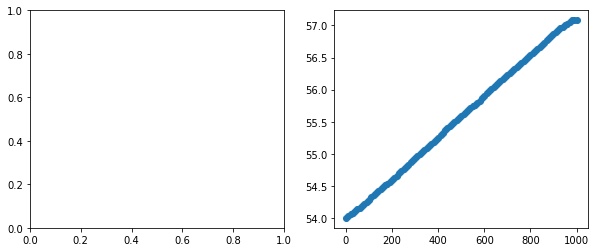

In [463]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o')
    fit_normal = np.polyfit(IV['Ib'], IV['Is'],1)
#    fit_spcond = np.polyfit(IV['Ib'][(IV['Ib']<650) & (IV['Ib']>600) ], IV['Is'][(IV['Ib']<650) & (IV['Ib']>600) ],1)

In [464]:
# use the same correction as 80mk
x_0 = -23.86172899 
y_0 = 53.88892785

In [465]:
IVs[0]['Ib'] = IVs[0]['Ib'] - x_0
IVs[0]['Is'] = IVs[0]['Is'] - y_0

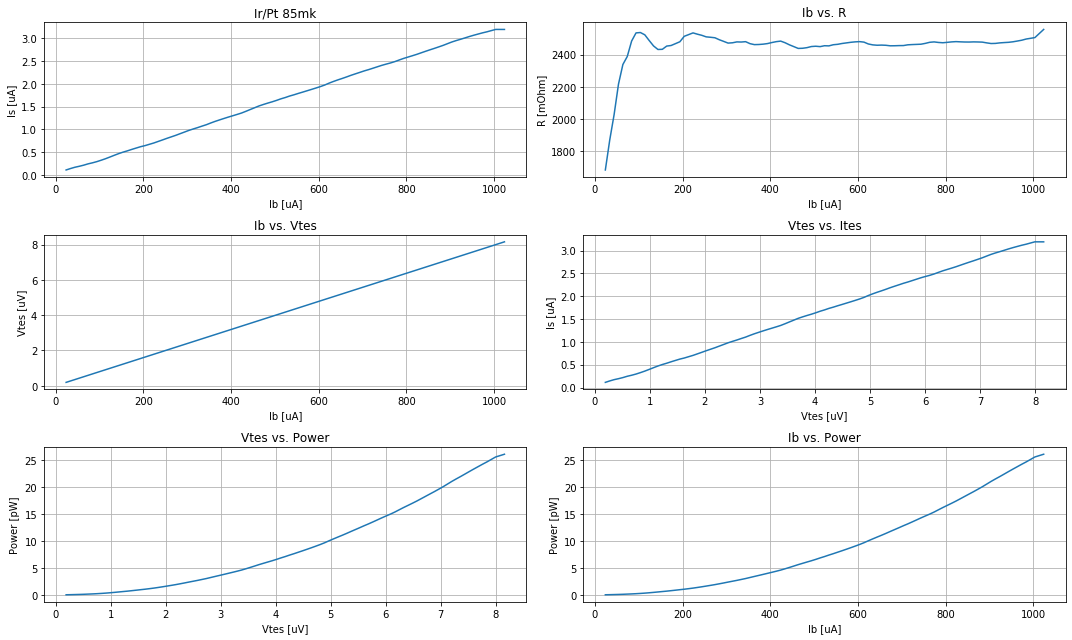

In [466]:
#Calculate resistance
Rp=2.5
Rsh=5.0+3.0
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

fig,ax = plt.subplots(3,2, figsize=(15,9))

for IV in IVs:

    axi=ax[0,0]
    axj=ax[0,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.grid()
    #axi.set_ylim(0,350)
#    axi.set_xlim(0,1500)
    
    
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
    
    axj.set_xlabel('Ib [uA]')
    axj.set_ylabel('R [mOhm]')
    axj.grid()
    #axi.set_ylim(0,350)
    #axj.set_xlim(0,1500)
    
    ax[1,0].plot(IV['Ib'],IV['Is']*IV['R']/1000)
    ax[1,0].set_xlabel('Ib [uA]')
    ax[1,0].set_ylabel('Vtes [uV]')
    ax[1,0].grid()

    ax[1,1].plot(IV['Is']*IV['R']/1000,IV['Is'])
    ax[1,1].set_ylabel('Is [uA]')
    ax[1,1].set_xlabel('Vtes [uV]')
    ax[1,1].grid()
    
    ax[2,0].plot(IV['Is']*IV['R']/1000,IV['Is']**2*IV['R']/1000)
    ax[2,0].set_xlabel('Vtes [uV]')
    ax[2,0].set_ylabel('Power [pW]')
    ax[2,0].grid()
    #axi.set_ylim(0,350)
    #ax[2,0].set_xlim(0,1500)    

    ax[2,1].plot(IV['Ib'],IV['Is']**2*IV['R']/1000)
    ax[2,1].set_xlabel('Ib [uA]')
    ax[2,1].set_ylabel('Power [pW]')
    ax[2,1].grid()
    #axi.set_ylim(0,350)
#    ax[2,1].set_xlim(0,1500)
    
    
#ax[0,0].set_title('PAS1')
ax[0,0].set_title('Ir/Pt 85mk')
ax[0,1].set_title("Ib vs. R")
ax[1,0].set_title("Ib vs. Vtes")
ax[1,1].set_title("Vtes vs. Ites")
ax[2,0].set_title("Vtes vs. Power")
ax[2,1].set_title("Ib vs. Power")

    
plt.tight_layout()

# Backup

IndexError: too many indices for array

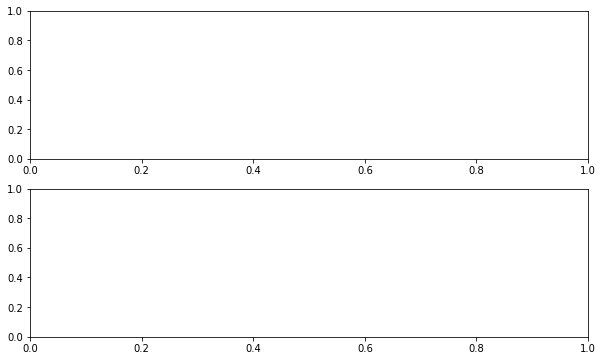

In [65]:
fig,ax = plt.subplots(2,2, figsize=(10,6))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0,0]
        axj=ax[1,0]
    else:
        axi=ax[0,1]
        axj=ax[1,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
for axi in ax[0]:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.set_xlim(0,1400)
    #axi.set_ylim(0,None)
    axi.grid()
    axi.legend()
    
for axi in ax[0]:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('R [mOhm]')
    axi.grid()
    #axi.set_ylim(0,350)
    axi.set_xlim(0,1000)
    
    axi.legend()
    
#ax[0,0].set_title('PAS1')
ax[0,1].set_title('PFS1')
    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

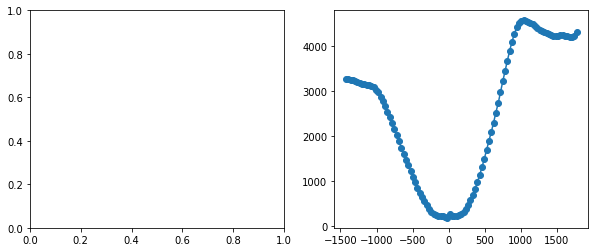

In [521]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['R'],'-o')

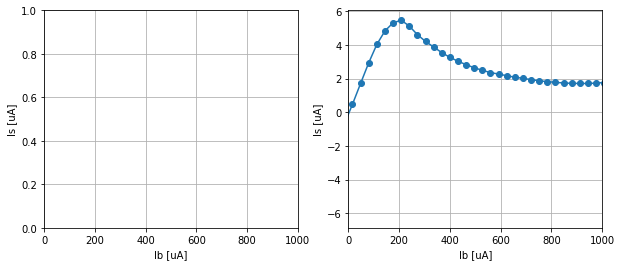

In [522]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
        
    axi.plot(IV['Ib'],IV['Is'],'-o',label=IV['temp'])

for axi in ax:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.set_xlim(0,1000)
    #axi.set_ylim(0,None)
    axi.grid()
#    axi.legend()

In [323]:
#Correct for SQUID jumps
#Use SC fits to calcuate jump size
Is_offset=[]
for IV in IVs:
    if IV['chan']=='PAS1':
        Is_offset.append(np.polyfit(IV['Ib'][IV['Ib']<25], IV['Is'][IV['Ib']<25], 1)[1])
    else:
        Is_offset.append(np.polyfit(IV['Ib'][IV['Ib']<50], IV['Is'][IV['Ib']<50], 1)[1])

In [324]:
Is_offset

[-5.374183639832675]

In [302]:
#The 60mK curves don't have jumps, use them as the standards.
#offsets_PA=Is_offset[::2]-Is_offset[6]
#offsets_PF=Is_offset[1::2]-Is_offset[7]
print("PAS1: "+str(offsets_PA))
print("PFS1: "+str(offsets_PF))
njump_PA=np.array([2,1,2,0])#This array arrangement is getting to be clumsy...
njump_PF=np.array([0,2,1,0])

jump_size_PA=np.mean(offsets_PA[njump_PA>0]/njump_PA[njump_PA>0])
jump_size_PF=np.mean(offsets_PF[njump_PF>0]/njump_PF[njump_PF>0])
print("Jump_sizes [uA]: {0:.2f}, {1:.2f}".format(jump_size_PA,jump_size_PF))
#Array of Ib values where jumps occur. Shift everything at lower Ib than the jump
jump_size_PA=14.84
jump_size_PF=17.99

NameError: name 'offsets_PA' is not defined

In [303]:
#import copy
#IVs_backup=copy.deepcopy(IVs)
#IVs=copy.deepcopy(IVs_backup)

In [315]:
#Positions of SQUID jumps
jump_PAS1={'20 mK':[56,52],'40 mK':[57],'50 mK':[47,42],'60 mK':[]}
jump_PFS1={'20 mK':[],'40 mK':[97,92],'50 mK':[77],'60 mK':[]}

for IV in IVs:
    if IV['chan']=='PAS1':
        for jpos in jump_PAS1[IV['temp']]:
            IV['Is'][IV['Ib']<jpos]-=jump_size_PA
    
    if IV['chan']=='PFS1':
        for jpos in jump_PFS1[IV['temp']]:
            IV['Is'][IV['Ib']<jpos]-=jump_size_PF

No handles with labels found to put in legend.


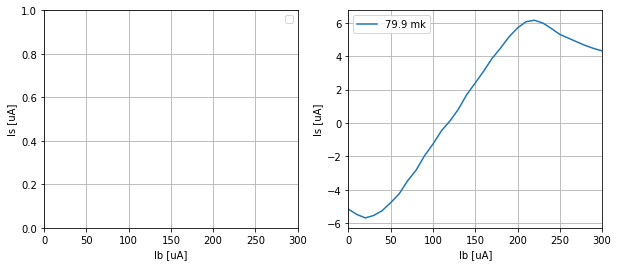

In [325]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
        
    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])

for axi in ax:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.set_xlim(0,300)
    #axi.set_ylim(0,None)
    axi.grid()
    axi.legend()

In [326]:
#Calculate resistance
Rsh=5.0+3.0 #[mOhm]
Rp=2.5
for IV in IVs:
    IV['R']=Rsh*(IV['Ib']/IV['Is']-1)-Rp

No handles with labels found to put in legend.
No handles with labels found to put in legend.


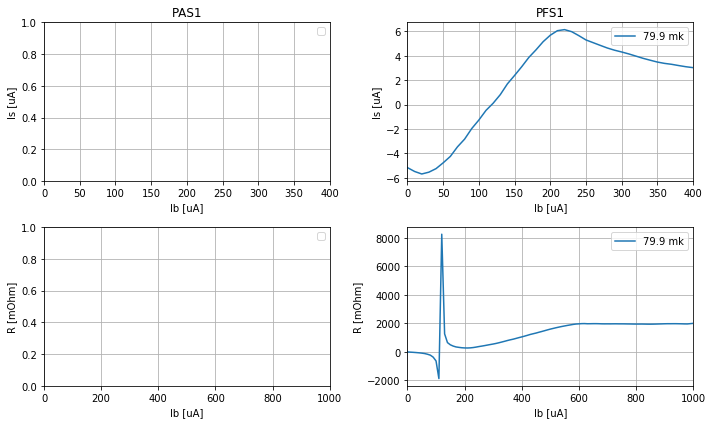

In [327]:
fig,ax = plt.subplots(2,2, figsize=(10,6))

for IV in IVs:
    if IV['chan']=='PAS1':
        axi=ax[0,0]
        axj=ax[1,0]
    else:
        axi=ax[0,1]
        axj=ax[1,1]

    axi.plot(IV['Ib'],IV['Is'],'-',label=IV['temp'])
    axj.plot(IV['Ib'],IV['R'],'-',label=IV['temp'])
    
for axi in ax[0]:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.set_xlim(0,400)
    #axi.set_ylim(0,None)
    axi.grid()
    axi.legend()
    
for axi in ax[1]:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('R [mOhm]')
    axi.grid()
    #axi.set_ylim(0,350)
    axi.set_xlim(0,1000)
    
    axi.legend()
    
ax[0,0].set_title('PAS1')
ax[0,1].set_title('PFS1')
    
plt.tight_layout()
#plt.savefig("images/R5_IbIs.png")

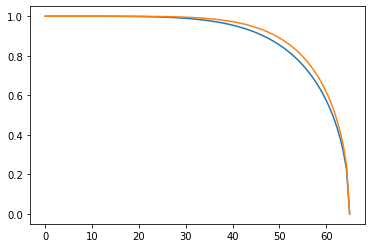

In [28]:
ttt=np.linspace(0,65,100)
plt.plot(ttt,((65**5-ttt**5)**0.5)/(65**(5/2)))
plt.plot(ttt,((65**6-ttt**6)**0.5)/(65**(6/2)))

327.8401588396788
['0.22', '0.32', '0.41', '0.51', '0.63']


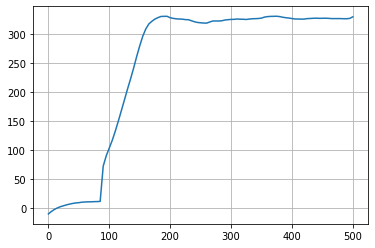

In [29]:
#Calculate position in transition for a few Ib values

plt.plot(IVs[0]['Ib'],IVs[0]['R'])
plt.grid()
Ibs=[90,100,110,120,130]
Rmax=np.mean(IVs[0]['R'][IVs[0]['Ib']>300])
print(Rmax)
frac=[np.interp(Ibs_i,IVs[0]['Ib'],IVs[0]['R'])/Rmax for Ibs_i in Ibs]
print(['{:.2f}'.format(_) for _ in frac])
#['0.233', '0.321', '0.405', '0.495', '0.587']

In [30]:
#Compare to IbIs with negative polarity to confirm Ib,Is offsets
IVrev=[{'series':'25200302_1600','chan':'PAS1','temp':'40 mK'},
       {'series':'25200302_1625','chan':'PFS1','temp':'40 mK'}]

In [43]:
#Calculate trace means
##This takes a while. Can also load saved ones below##
if True:
    IVrev = pickle.load( open( "data/R5_IbIs_rev.pkl", "rb" ) )
else:
    for i,IVi in enumerate(IVrev):
        dumplist=sorted(glob(dir+IVi['series']+"/25*"))
        means_dump=[]
        for dump in dumplist:
            res=io.getRawEvents("",dump)
            if 'Z1' in res.keys():
                traces=res[det][IVi['chan']]
                mean_i=[np.mean(tr) for tr in traces]
                means_dump+=(mean_i)
        means_dump=np.array(means_dump)
        IVi['means']=means_dump
        
        #Cluster it
        ev=np.arange(len(means_dump))
        X=np.array([ev,means_dump*1e6/traceGain])
        kmeans = KMeans(n_clusters=Nmeas, random_state=0).fit(X.T)

        ev_cent=kmeans.cluster_centers_.T[0]
        Is_cent=kmeans.cluster_centers_.T[1]

        Is=Is_cent[np.argsort(ev_cent)][::-1]

        Ib=np.linspace(0,-500,Nmeas)
        IVi['Ib']=Ib
        IVi['Is']=Is
        
        print("{}%".format(np.round(100*(i+1)/len(IVrev))), end="\r", flush=True)
        pickle.dump( IVrev, open( "data/R5_IbIs_rev.pkl", "wb" ) )

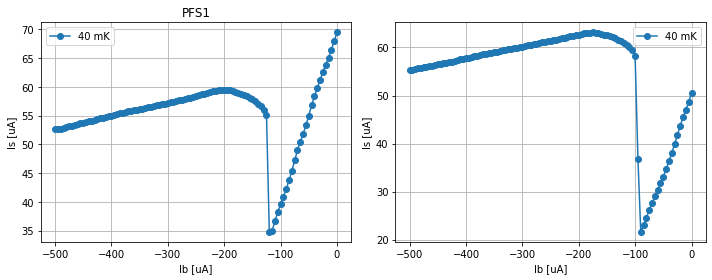

In [44]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVrev:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]

    axi.plot(IV['Ib'],IV['Is'],'-o',label=IV['temp'])
    
for axi in ax:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    #axi.set_xlim(0,400)
    #axi.set_ylim(0,None)
    axi.grid()
    axi.legend()
    
    
ax[0].set_title('PAS1')
ax[0].set_title('PFS1')
    
plt.tight_layout()

In [45]:
#Use Normal intercepts to correct for Is offset
for IV in IVrev:
    offset=np.polyfit(IV['Ib'][IV['Ib']<-300], IV['Is'][IV['Ib']<-300], 1)[1]
    IV['Is']-=offset

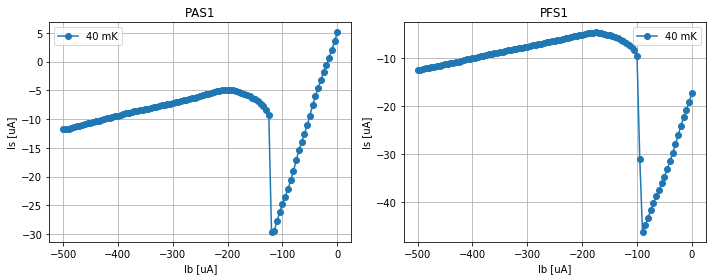

In [46]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

for IV in IVrev:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]

    axi.plot(IV['Ib'],IV['Is'],'-o',label=IV['temp'])
    
for axi in ax:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    #axi.set_xlim(0,400)
    #axi.set_ylim(0,None)
    axi.grid()
    axi.legend()
    
    
ax[0].set_title('PAS1')
ax[1].set_title('PFS1')
    
plt.tight_layout()

In [47]:
#Positions of SQUID jumps. Use jump size calculated earlier
jump_PAS1rev={'40 mK':[]}
jump_PFS1rev={'40 mK':[-97]}

for IV in IVrev:
    if IV['chan']=='PAS1':
        for jpos in jump_PAS1rev[IV['temp']]:
            IV['Is'][IV['Ib']>jpos]+=jump_size_PA
    
    if IV['chan']=='PFS1':
        for jpos in jump_PFS1rev[IV['temp']]:
            IV['Is'][IV['Ib']>jpos]+=jump_size_PF

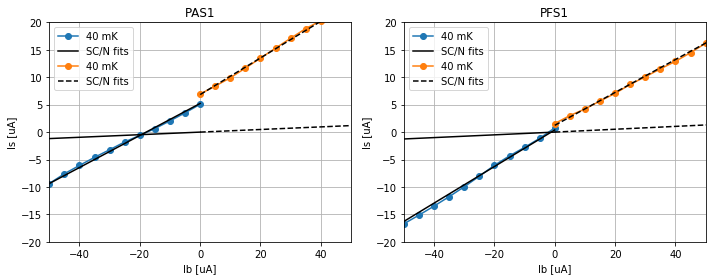

In [75]:
#Now plot both the pos and neg IV scans for 40 mK
#Lower plots are a zoom in
fig,ax = plt.subplots(1,2, figsize=(10,4))

Ib_neg=np.linspace(-500,0,100)
Ib_pos=np.linspace(0,500,100)

for IV in IVrev:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o',label=IV['temp'])
    #Include SC,N fits
    fpars=np.polyfit(IV['Ib'][IV['Ib']<-300], IV['Is'][IV['Ib']<-300], 1)
    axi.plot(Ib_neg,np.poly1d(fpars)(Ib_neg),'k',label='SC/N fits')
    fpars=np.polyfit(IV['Ib'][IV['Ib']>-75], IV['Is'][IV['Ib']>-75], 1)
    axi.plot(Ib_neg,np.poly1d(fpars)(Ib_neg),'k')

for IV in [IVs[2],IVs[3]]:
    if IV['chan']=='PAS1':
        axi=ax[0]
    else:
        axi=ax[1]
    axi.plot(IV['Ib'],IV['Is'],'-o',label=IV['temp'])
    #Include SC,N fits
    fpars=np.polyfit(IV['Ib'][IV['Ib']>300], IV['Is'][IV['Ib']>300], 1)
    axi.plot(Ib_pos,np.poly1d(fpars)(Ib_pos),'--k',label='SC/N fits')
    fpars=np.polyfit(IV['Ib'][IV['Ib']<75], IV['Is'][IV['Ib']<75], 1)
    axi.plot(Ib_pos,np.poly1d(fpars)(Ib_pos),'--k')

for axi in ax:
    axi.set_xlabel('Ib [uA]')
    axi.set_ylabel('Is [uA]')
    axi.set_xlim(-50,50)
    axi.set_ylim(-20,20)
    #axi.set_ylim(-35,35)
    axi.grid()
    axi.legend()
    
    
ax[0].set_title('PAS1')
ax[1].set_title('PFS1')
    
plt.tight_layout()
#plt.savefig("images/R5_IbIs_symmetry_zoom.png")